### Importing of libraries

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings


### Set MKL thread limit to avoid memory leak issues

In [55]:
# Suppress MKL warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

### Load the datasets

In [4]:


customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")


### Feature Engineering


### Aggregate transaction-level data into customer-level data

In [12]:

customer_features = transactions.groupby("CustomerID").agg(
    {
        "TransactionID": "count",  
        "TotalValue": "sum", 
        "ProductID": lambda x: x.mode()[0] if not x.mode().empty else None, 
    }
).rename(columns={
    "TransactionID": "PurchaseFrequency",
    "TotalValue": "TotalSpend",
    "ProductID": "MostPurchasedProduct"
}).reset_index()



### Merge with customer demographic data



In [15]:
customer_features = pd.merge(customer_features, customers, on="CustomerID", how="left")



### One-hot encode the 'Region' column


In [18]:
encoder = OneHotEncoder()
region_encoded = encoder.fit_transform(customer_features[["Region"]]).toarray()
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(["Region"]))



### Concatenate with original features

In [21]:
customer_features = pd.concat([customer_features, region_encoded_df], axis=1)
customer_features.drop(columns=["Region", "CustomerName", "SignupDate"], inplace=True)



### Normalize numerical columns


In [24]:
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(customer_features[["PurchaseFrequency", "TotalSpend"]])
normalized_features_df = pd.DataFrame(normalized_features, columns=["NormPurchaseFrequency", "NormTotalSpend"])



### Add normalized columns to the feature set

In [27]:
customer_features = pd.concat([customer_features.reset_index(drop=True), normalized_features_df], axis=1)


### Clustering



### Select only numerical features for clustering


In [31]:
clustering_data = customer_features.drop(columns=["CustomerID", "PurchaseFrequency", "TotalSpend", "MostPurchasedProduct"])



### Choose number of clusters (2 to 10)


In [57]:
k_range = range(2, 11)
cluster_metrics = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(clustering_data)

    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(clustering_data, cluster_labels)
    silhouette_avg = silhouette_score(clustering_data, cluster_labels)
    
    cluster_metrics.append((k, db_index, silhouette_avg))

# Convert cluster metrics to DataFrame
metrics_df = pd.DataFrame(cluster_metrics, columns=["NumClusters", "DaviesBouldinIndex", "SilhouetteScore"])

# Choose the best number of clusters (lowest DB index)
best_k = metrics_df.loc[metrics_df["DaviesBouldinIndex"].idxmin(), "NumClusters"]

# Final clustering with the best number of clusters
final_kmeans = KMeans(n_clusters=int(best_k), random_state=42, n_init=10)
customer_features["ClusterLabel"] = final_kmeans.fit_predict(clustering_data)


### Visualization

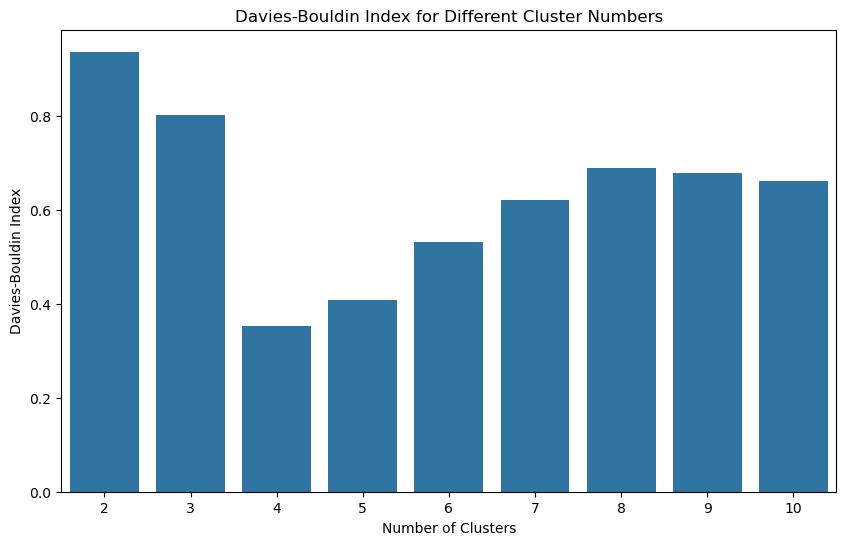

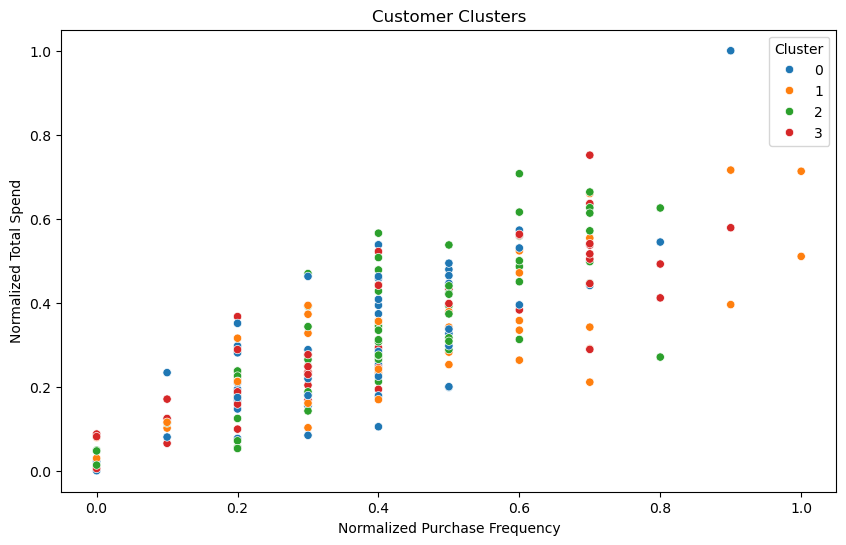

In [38]:

plt.figure(figsize=(10, 6))
sns.barplot(x="NumClusters", y="DaviesBouldinIndex", data=metrics_df)
plt.title("Davies-Bouldin Index for Different Cluster Numbers")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features["NormPurchaseFrequency"],
    y=customer_features["NormTotalSpend"],
    hue=customer_features["ClusterLabel"],
    palette="tab10"
)
plt.title("Customer Clusters")
plt.xlabel("Normalized Purchase Frequency")
plt.ylabel("Normalized Total Spend")
plt.legend(title="Cluster")
plt.show()

